In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from itertools import product
import io

df1 = pd.read_csv("./data/student_dataset.csv")
df2 = pd.read_csv(".data/scholarship_dataset.csv")

df3=df1.merge(df2, how='cross')



In [3]:
def generate_output(row):
    if (((row['Education_Level'] =='BS') & (row['Education_Preference']=='Masters')) | ((row['Education_Level'] =='Masters') & (row['Education_Preference']=='PhD')) | ((row['Education_Level'] =='PhD') & (row['Education_Preference']=='PhD'))) | (row['Country_Preference'] == row['Country_of_Scholarship']) | (row['Domain_Area'] == row['Eligible_Domain']):
        return 1
    else:
        return 0

In [4]:
df3['Target'] = df3.apply(generate_output, axis=1)

df3.drop('Name', axis=1, inplace=True)
df3.drop('CGPA', axis=1, inplace=True)
df3.drop('Budget_Prefrence', axis=1, inplace=True)
df3.drop('Scholarship_Name', axis=1, inplace=True)
df3.drop('Scholarship_Type', axis=1, inplace=True)
df3.drop('Scholarship_Budget', axis=1, inplace=True)
df3.drop('Required_GPA', axis=1, inplace=True)

df3.to_csv("combined_dataset.csv", index=False)

In [5]:
print(df3['Target'].value_counts())

1    135329
0    114671
Name: Target, dtype: int64


In [6]:
df3 = pd.read_csv("combined_dataset.csv")

# Split the dataset into features (X) and target variable (y)
X = df3.drop('Target', axis=1)
y = df3['Target']

# One-hot encode categorical columns
categorical_columns = ["Education_Level", "Country_Preference", "Domain_Area",
                       "Education_Preference", "Country_of_Scholarship",
                       "Eligible_Domain"]

X = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [8]:
# Build a simple neural network model
model = Sequential([
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with a specified number of epochs
epochs = 10  # Adjust the number of epochs as needed
history=model.fit(X_train_scaled, y_train, epochs=epochs, validation_data=(X_test_scaled, y_test), callbacks=[early_stop])

Epoch 1/10
6250/6250 [==============================] - 15s 2ms/step - loss: 0.4127 - accuracy: 0.8374 - val_loss: 0.2975 - val_accuracy: 0.8992
Epoch 2/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.2663 - accuracy: 0.9110 - val_loss: 0.2465 - val_accuracy: 0.9207
Epoch 3/10
6250/6250 [==============================] - 15s 2ms/step - loss: 0.2351 - accuracy: 0.9238 - val_loss: 0.2318 - val_accuracy: 0.9245
Epoch 4/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.2294 - accuracy: 0.9251 - val_loss: 0.2396 - val_accuracy: 0.9197
Epoch 5/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.2286 - accuracy: 0.9252 - val_loss: 0.2286 - val_accuracy: 0.9250
Epoch 6/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.2282 - accuracy: 0.9252 - val_loss: 0.2287 - val_accuracy: 0.9250
Epoch 7/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.2280 - accuracy: 0.9253 - val_loss: 0.2364 - val_ac

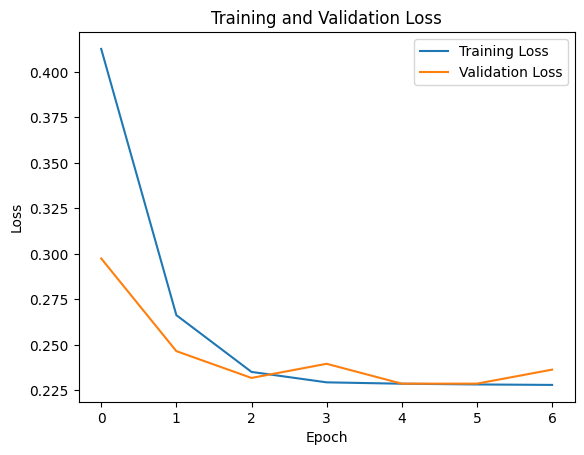

In [9]:
# Accessing loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict probabilities for binary classification
y_pred_prob = model.predict(X_test_scaled)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Ensure y_test and y_pred have the same data type and shape
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


1563/1563 [==============================] - 2s 1ms/step
Accuracy: 0.92136
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22994
           1       0.87      1.00      0.93     27006

    accuracy                           0.92     50000
   macro avg       0.94      0.91      0.92     50000
weighted avg       0.93      0.92      0.92     50000

Confusion Matrix:
[[19118  3876]
 [   56 26950]]


In [11]:
tf.saved_model.save(model, 'recommender_system')


In [12]:
from google.colab import files
import os

dir_to_zip = 'recommender_system'
output_filename = 'recommender_system.zip'
delete_dir_after_download = "No"

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !pip install tensorflowjs

In [ ]:
# import tensorflowjs as tfjs

In [ ]:
# tfjs.converters.save_keras_model(model,'/content/')

In [ ]:
# from google.colab import files

In [ ]:
# files.download('model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# files.download('group1-shard1of1.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>